In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [37]:
def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""

    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*60)

    # 1. Distribution Analysis
    print("\n1. DISTRIBUTION ANALYSIS")
    print("-" * 30)

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Create subplots for distributions
    n_cols = len(numeric_cols)
    fig, axes = plt.subplots(nrows=(n_cols+2)//3, ncols=3, figsize=(15, 4*((n_cols+2)//3)))
    axes = axes.flatten() if n_cols > 3 else [axes]

    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i], alpha=0.7)
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Correlation Analysis
    print("\n2. CORRELATION ANALYSIS")
    print("-" * 30)

    correlation_matrix = df[numeric_cols].corr()

    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find high correlations
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature1': correlation_matrix.columns[i],
                    'Feature2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })

    if high_corr:
        print("\nHigh Correlations (>0.7):")
        for corr in high_corr:
            print(f"   {corr['Feature1']} ↔ {corr['Feature2']}: {corr['Correlation']:.3f}")

    # 3. Time Series Analysis (if Year column exists)
    if 'Year' in df.columns:
        print("\n3. TIME SERIES TRENDS")
        print("-" * 30)

        yearly_trends = df.groupby('Year')[numeric_cols].mean()

        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_cols):
            if col != 'Year':
                plt.subplot(3, 3, i+1)
                plt.plot(yearly_trends.index, yearly_trends[col], marker='o', linewidth=2)
                plt.title(f'{col} Trend Over Time')
                plt.xlabel('Year')
                plt.ylabel(col)
                plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('time_trends.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 4. Outlier Detection
    print("\n4. OUTLIER DETECTION")
    print("-" * 30)

    outliers_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count = len(outliers)
        outliers_percentage = (outliers_count / len(df)) * 100

        outliers_summary.append({
            'Column': col,
            'Outliers_Count': outliers_count,
            'Outliers_Percentage': outliers_percentage,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })

    outliers_df = pd.DataFrame(outliers_summary)
    print(outliers_df.to_string(index=False))

    return correlation_matrix, outliers_df

In [38]:
def data_transformation(df):
    """Data cleaning and transformation"""

    print("\n" + "="*60)
    print("DATA TRANSFORMATION")
    print("="*60)

    df_transformed = df.copy()

    # 1. Handle missing values
    print("\n1. HANDLING MISSING VALUES")
    print("-" * 35)

    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_transformed.select_dtypes(include=['object']).columns

    # Fill numeric missing values with median
    for col in numeric_cols:
        if df_transformed[col].isnull().sum() > 0:
            median_val = df_transformed[col].median()
            df_transformed[col].fillna(median_val, inplace=True)
            print(f"   {col}: Filled with median ({median_val:.2f})")

    # Fill categorical missing values with mode
    for col in categorical_cols:
        if df_transformed[col].isnull().sum() > 0:
            mode_val = df_transformed[col].mode()[0]
            df_transformed[col].fillna(mode_val, inplace=True)
            print(f"   {col}: Filled with mode ({mode_val})")

    # 2. Remove outliers (optional - using IQR method)
    print("\n2. OUTLIER TREATMENT")
    print("-" * 25)

    original_size = len(df_transformed)

    for col in numeric_cols:
        Q1 = df_transformed[col].quantile(0.25)
        Q3 = df_transformed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers instead of removing them
        df_transformed[col] = np.clip(df_transformed[col], lower_bound, upper_bound)

    print(f"   Outliers capped using IQR method")
    print(f"   Dataset size maintained: {len(df_transformed)} rows")

    # 3. Feature Engineering
    print("\n3. FEATURE ENGINEERING")
    print("-" * 30)

    # Create new features based on existing ones
    if 'Temperature_Celsius' in df_transformed.columns:
        df_transformed['Temperature_Fahrenheit'] = df_transformed['Temperature_Celsius'] * 9/5 + 32
        print("   Created: Temperature_Fahrenheit")

    if 'CO2_Emissions_MtCO2' in df_transformed.columns and 'Year' in df_transformed.columns:
        df_transformed['CO2_Growth_Rate'] = df_transformed.groupby('Country')['CO2_Emissions_MtCO2'].pct_change()
        print("   Created: CO2_Growth_Rate")

    if 'Extreme_Weather_Events' in df_transformed.columns and 'Year' in df_transformed.columns:
        df_transformed['Weather_Events_MA'] = df_transformed.groupby('Country')['Extreme_Weather_Events'].rolling(window=3).mean().reset_index(0, drop=True)
        print("   Created: Weather_Events_MA (3-year moving average)")

    # Climate Risk Score (composite feature)
    if all(col in df_transformed.columns for col in ['Temperature_Celsius', 'Extreme_Weather_Events', 'Sea_Level_mm']):
        # Normalize components to 0-1 scale
        temp_norm = (df_transformed['Temperature_Celsius'] - df_transformed['Temperature_Celsius'].min()) / (df_transformed['Temperature_Celsius'].max() - df_transformed['Temperature_Celsius'].min())
        events_norm = (df_transformed['Extreme_Weather_Events'] - df_transformed['Extreme_Weather_Events'].min()) / (df_transformed['Extreme_Weather_Events'].max() - df_transformed['Extreme_Weather_Events'].min())
        sea_norm = (df_transformed['Sea_Level_mm'] - df_transformed['Sea_Level_mm'].min()) / (df_transformed['Sea_Level_mm'].max() - df_transformed['Sea_Level_mm'].min())

        df_transformed['Climate_Risk_Score'] = (temp_norm + events_norm + sea_norm) / 3
        print("   Created: Climate_Risk_Score (composite index)")

    return df_transformed

In [39]:
def feature_scaling(df_transformed):
    """Apply feature scaling"""

    print("\n4. FEATURE SCALING")
    print("-" * 25)

    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    df_scaled = df_transformed.copy()

    # Standard Scaling
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])

    print("   Applied StandardScaler to all numeric features")
    print("   Features now have mean=0 and std=1")

    return df_scaled, scaler

In [40]:
def feature_selection(df_transformed, target_column=None):
    """Feature selection using multiple methods"""

    print("\n" + "="*60)
    print("FEATURE SELECTION")
    print("="*60)

    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns

    # If no target specified, use Climate_Risk_Score if available
    if target_column is None:
        if 'Climate_Risk_Score' in df_transformed.columns:
            target_column = 'Climate_Risk_Score'
        elif 'Temperature_Celsius' in df_transformed.columns:
            target_column = 'Temperature_Celsius'
        else:
            target_column = numeric_cols[0]

    print(f"Using '{target_column}' as target variable")

    # Prepare features and target
    X = df_transformed[numeric_cols].drop(columns=[target_column])
    y = df_transformed[target_column]

    # Remove any remaining NaN values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

    # 1. Correlation-based selection
    print("\n1. CORRELATION-BASED SELECTION")
    print("-" * 40)

    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    high_corr_features = correlations[correlations > 0.3].index.tolist()

    print("Features with correlation > 0.3:")
    for feature in high_corr_features:
        print(f"   {feature}: {correlations[feature]:.3f}")

    # 2. Statistical selection (SelectKBest)
    print("\n2. STATISTICAL SELECTION (F-TEST)")
    print("-" * 40)

    selector = SelectKBest(score_func=f_regression, k=min(5, len(X.columns)))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    feature_scores = selector.scores_

    print("Top 5 features by F-score:")
    for feature, score in zip(selected_features, feature_scores[selector.get_support()]):
        print(f"   {feature}: {score:.2f}")

    # 3. Random Forest Feature Importance
    print("\n3. RANDOM FOREST IMPORTANCE")
    print("-" * 35)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Feature importance ranking:")
    for _, row in feature_importance.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.3f}")

    # 4. PCA Analysis
    print("\n4. PRINCIPAL COMPONENT ANALYSIS")
    print("-" * 40)

    # Standardize features for PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    pca.fit(X_scaled)

    # Calculate cumulative explained variance
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

    print(f"Components explaining 90% variance: {n_components_90}")
    print(f"Components explaining 95% variance: {n_components_95}")
    print("Top 3 components explain {:.1f}% of variance".format(cumsum_variance[2] * 100))

    # Create feature selection summary
    feature_selection_summary = {
        'high_correlation_features': high_corr_features,
        'statistical_features': selected_features,
        'rf_top_features': feature_importance.head(5)['Feature'].tolist(),
        'pca_components_90': n_components_90,
        'target_variable': target_column
    }

    return feature_selection_summary, feature_importance

In [41]:
def create_sample_data():
    """Create sample climate data"""
    print("Creating sample climate data...")

    np.random.seed(42)
    years = list(range(2000, 2025))
    countries = ['USA', 'China', 'India', 'Brazil', 'Russia', 'Japan']

    data = []
    for year in years:
        for country in countries:
            base_temp = np.random.normal(15, 5)
            temp_anomaly = (year - 2000) * 0.05 + np.random.normal(0, 0.5)

            row = {
                'Year': year,
                'Country': country,
                'Temperature_Celsius': base_temp + temp_anomaly,
                'CO2_Emissions_MtCO2': np.random.lognormal(8, 1),
                'Precipitation_mm': np.random.gamma(2, 400),
                'Sea_Level_mm': 1500 + (year - 2000) * 3.2 + np.random.normal(0, 10),
                'Extreme_Weather_Events': np.random.poisson(5),
                'Forest_Coverage_percent': max(0, 50 + np.random.normal(0, 20)),
                'Renewable_Energy_percent': min(100, max(0, (year - 2000) * 1.5 + np.random.normal(0, 5)))
            }

            if np.random.random() < 0.05:
                col_to_miss = np.random.choice(['CO2_Emissions_MtCO2', 'Forest_Coverage_percent'])
                row[col_to_miss] = np.nan

            data.append(row)

    df = pd.DataFrame(data)
    df.to_csv('sample_climate_data.csv', index=False)
    return df

In [42]:
def main():
    """Main analysis pipeline"""

    print("="*80)
    print("ENHANCED CLIMATE RISK ANALYSIS WITH EDA & FEATURE ENGINEERING")
    print("="*80)

    # Load data
    dataset_paths = ["climate_change_dataset.csv", "sample_climate_data.csv"]
    df = None

    for path in dataset_paths:
        if Path(path).exists():
            df = pd.read_csv(path)
            print(f"Loaded dataset: {path}")
            break

    if df is None:
        df = create_sample_data()
        print("Created sample dataset")

    print(f"Dataset shape: {df.shape}")

    # Perform EDA
    correlation_matrix, outliers_summary = perform_eda(df)

    # Data transformation
    df_transformed = data_transformation(df)

    # Feature scaling
    df_scaled, scaler = feature_scaling(df_transformed)

    # Feature selection
    feature_summary, feature_importance = feature_selection(df_transformed)

    # Final summary
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - SUMMARY")
    print("="*80)
    print(f"Original features: {df.shape[1]}")
    print(f"After transformation: {df_transformed.shape[1]}")
    print(f"Recommended features: {len(feature_summary['rf_top_features'])}")
    print("\nKey insights:")
    print(f"- Target variable: {feature_summary['target_variable']}")
    print(f"- Top predictive feature: {feature_importance.iloc[0]['Feature']}")
    print(f"- Features for 90% variance: {feature_summary['pca_components_90']}")

    print("\nFiles created:")
    print("- distributions.png")
    print("- correlation_heatmap.png")
    print("- time_trends.png")

    return df_transformed, feature_summary

ENHANCED CLIMATE RISK ANALYSIS WITH EDA & FEATURE ENGINEERING
Loaded dataset: climate_change_dataset.csv
Dataset shape: (1000, 10)

EXPLORATORY DATA ANALYSIS (EDA)

1. DISTRIBUTION ANALYSIS
------------------------------


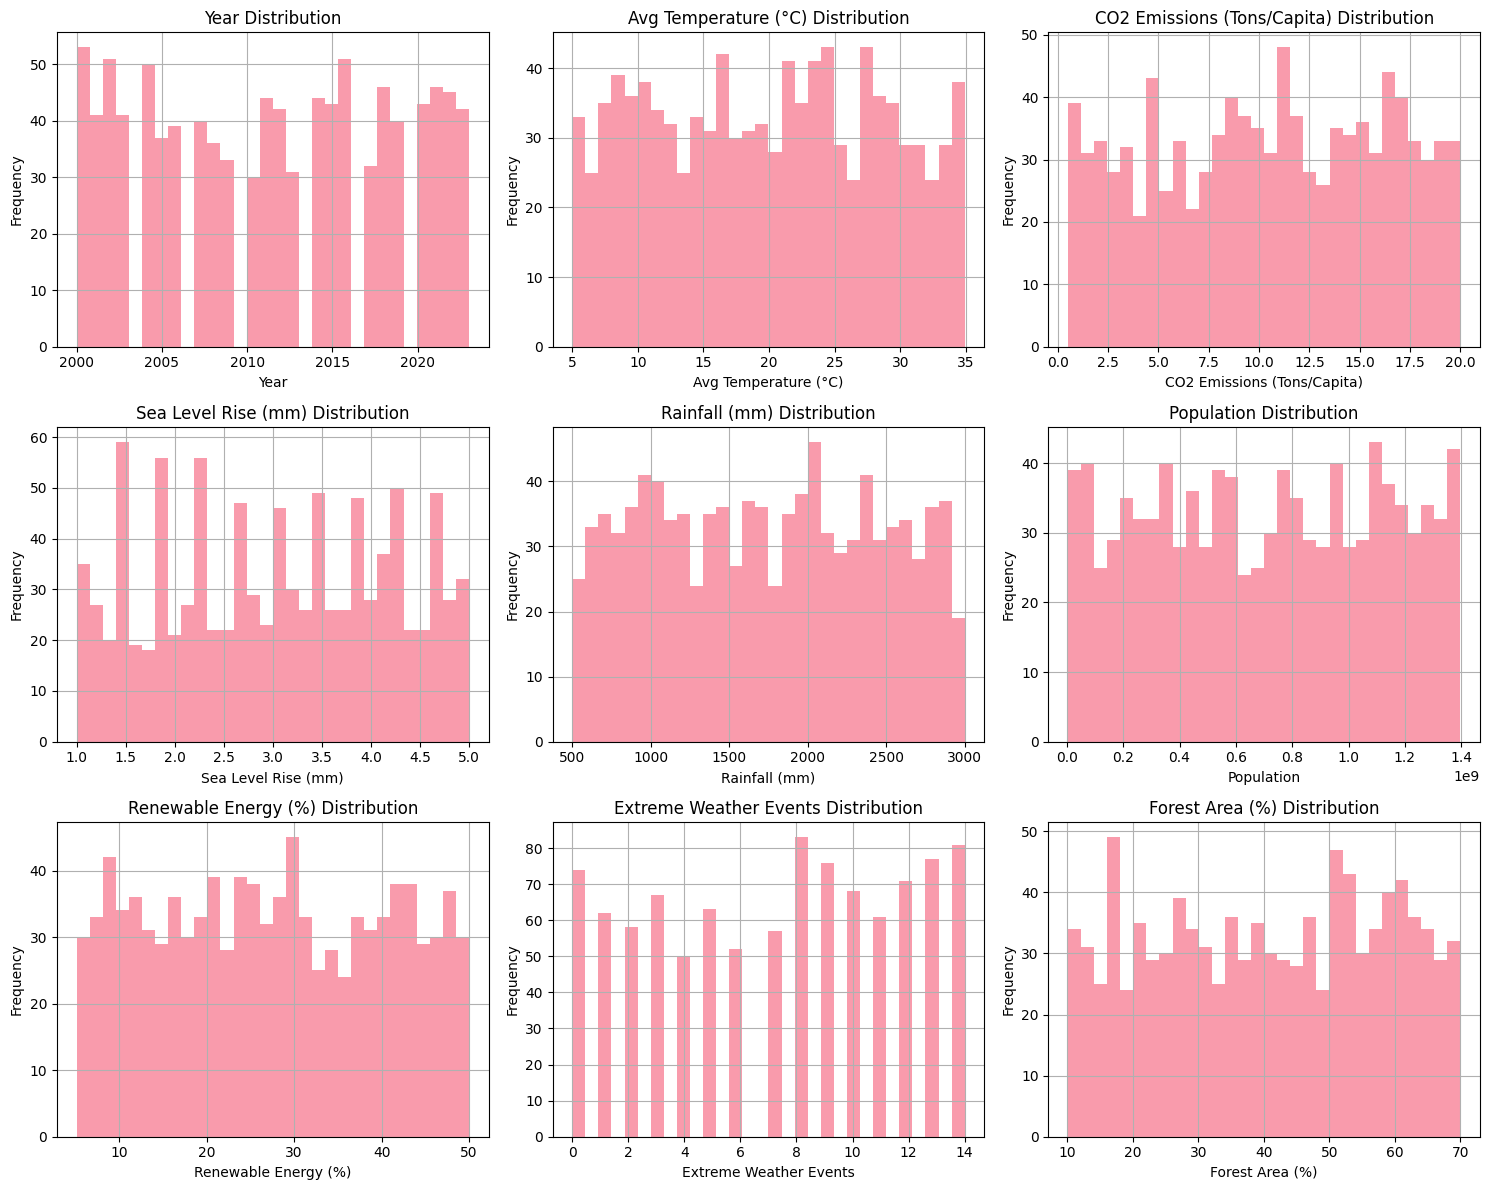


2. CORRELATION ANALYSIS
------------------------------


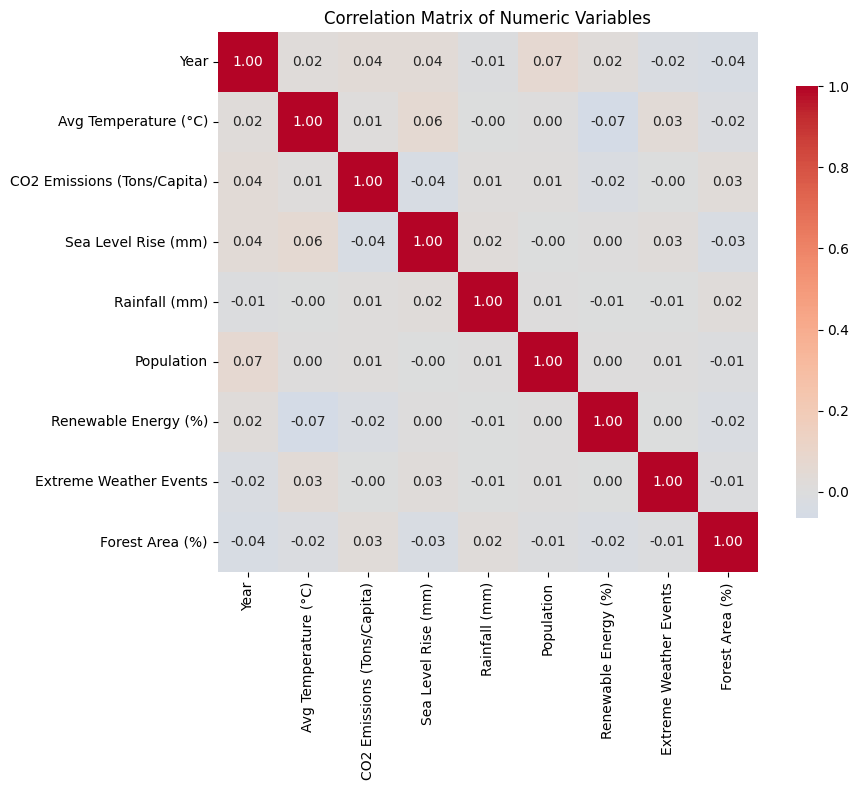


3. TIME SERIES TRENDS
------------------------------


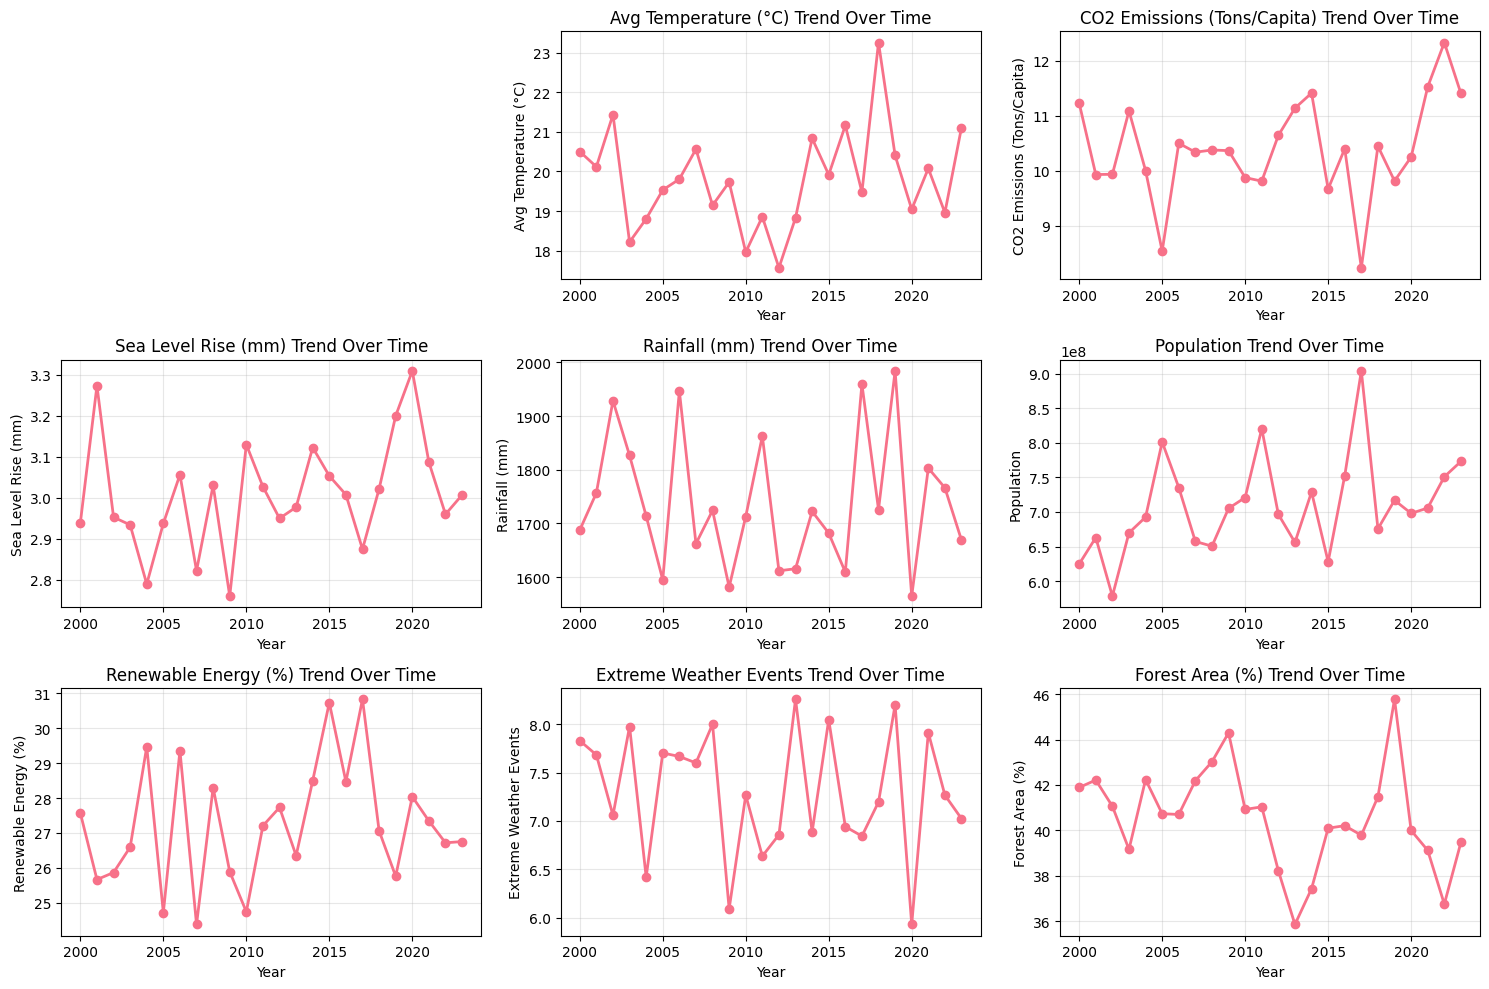


4. OUTLIER DETECTION
------------------------------
                     Column  Outliers_Count  Outliers_Percentage   Lower_Bound  Upper_Bound
                       Year               0                  0.0  1.985500e+03 2.037500e+03
       Avg Temperature (°C)               0                  0.0 -1.040000e+01 4.980000e+01
CO2 Emissions (Tons/Capita)               0                  0.0 -9.162500e+00 3.013750e+01
        Sea Level Rise (mm)               0                  0.0 -1.000000e+00 7.000000e+00
              Rainfall (mm)               0                  0.0 -7.968750e+02 4.258125e+03
                 Population               0                  0.0 -7.517416e+08 2.169234e+09
       Renewable Energy (%)               0                  0.0 -1.813750e+01 7.316250e+01
     Extreme Weather Events               0                  0.0 -9.000000e+00 2.300000e+01
            Forest Area (%)               0                  0.0 -1.970000e+01 1.011000e+02

DATA TRANSFORMATION

1. HA

In [43]:
if __name__ == "__main__":
    df_final, summary = main()

In [45]:
# Import necessary libraries for modeling
# from analysis_pipeline import create_sample_data, data_transformation, feature_scaling, feature_selection # This line is not needed
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MODEL TRAINING SCRIPT STARTED")
print("="*80)

# 1. Load and Prepare Data
# We re-run the pipeline to get the exact data artifacts we need.
# The functions create_sample_data, data_transformation, feature_scaling, and feature_selection
# are assumed to be defined in previous cells and accessible in the current scope.
df = create_sample_data()
df_transformed = data_transformation(df)
df_scaled, scaler = feature_scaling(df_transformed)
feature_summary, feature_importance = feature_selection(df_transformed)

# 2. Select Features and Target based on Analysis
# Ensure 'Climate_Risk_Score' is handled if it doesn't exist
if 'Climate_Risk_Score' in df_transformed.columns:
    target_variable = 'Climate_Risk_Score'
elif 'Avg Temperature (°C)' in df_transformed.columns:
    target_variable = 'Avg Temperature (°C)'
else:
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        target_variable = numeric_cols[0]
    else:
        print("No numeric columns available to be used as target variable.")
        # Handle the case where no target variable can be determined
        # This might involve raising an error or returning None
        # For now, we'll print a message and exit or skip training
        print("Skipping model training due to no available target variable.")
        # You might want to add a return statement here or handle this case appropriately
        # return


# Use the top 5 most important features from the Random Forest analysis
top_features = feature_importance.head(5)['Feature'].tolist()

print(f"\n[INFO] Target Variable: {target_variable}")
print(f"[INFO] Selected Model Features: {top_features}")

# 3. Prepare Final DataFrame for Modeling
# Feature engineering (rolling, pct_change) can create NaNs. We must drop them.
# Ensure selected features are in the dataframe before dropping NaNs
available_features = [f for f in top_features if f in df_transformed.columns]
if target_variable in df_transformed.columns:
    combined_cols = available_features + [target_variable]
    final_df = df_transformed[combined_cols].dropna()
else:
    print(f"Target variable '{target_variable}' not found in the dataframe. Cannot train model.")
    # Handle this case appropriately, e.g., return or exit
    print("Skipping model training.")
    # You might want to add a return statement here
    # return


# Check if final_df is empty after dropping NaNs
if final_df.empty:
    print("After dropping NaNs, no data remains for training.")
    print("Skipping model training.")
    # You might want to add a return statement here
    # return

X = final_df[available_features]
y = final_df[target_variable]


# 4. Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n[INFO] Training data shape: {X_train.shape}")
print(f"[INFO] Testing data shape: {X_test.shape}")

# 5. Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
print("\n[SUCCESS] Linear Regression model trained.")

# 6. Evaluate the Model's Performance
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\nModel Performance on Test Data:")
print(f"  - R-squared (R²): {r2:.4f} (This means the model explains {r2:.1%} of the variance)")
print(f"  - Mean Squared Error (MSE): {mse:.4f}")

# 7. Save the Model and Preprocessing Artifacts for Deployment
# We save the model and a dictionary containing everything needed for preprocessing.
preprocessor = {
    'scaler': scaler, # Assuming 'scaler' is available from a previous cell's execution
    'scaler_columns': list(df_scaled.select_dtypes(include='number').columns), # All columns scaler was trained on
    'model_features': available_features # Only the columns the model needs (the ones available from top_features)
}

joblib.dump(model, 'climate_model.joblib')
joblib.dump(preprocessor, 'data_preprocessor.joblib')

print("\n[SUCCESS] Model and preprocessor saved successfully!")
print("  - climate_model.joblib")
print("  - data_preprocessor.joblib")
print("\n" + "="*80)
print("MODEL TRAINING SCRIPT FINISHED")
print("="*80)

MODEL TRAINING SCRIPT STARTED
Creating sample climate data...

DATA TRANSFORMATION

1. HANDLING MISSING VALUES
-----------------------------------
   CO2_Emissions_MtCO2: Filled with median (3312.23)
   Forest_Coverage_percent: Filled with median (51.07)

2. OUTLIER TREATMENT
-------------------------
   Outliers capped using IQR method
   Dataset size maintained: 150 rows

3. FEATURE ENGINEERING
------------------------------
   Created: Temperature_Fahrenheit
   Created: CO2_Growth_Rate
   Created: Weather_Events_MA (3-year moving average)
   Created: Climate_Risk_Score (composite index)

4. FEATURE SCALING
-------------------------
   Applied StandardScaler to all numeric features
   Features now have mean=0 and std=1

FEATURE SELECTION
Using 'Climate_Risk_Score' as target variable

1. CORRELATION-BASED SELECTION
----------------------------------------
Features with correlation > 0.3:
   Sea_Level_mm: 0.663
   Year: 0.558
   Temperature_Celsius: 0.544
   Temperature_Fahrenheit: 0.5